In [1]:
import numpy as np
import pandas as pd
from gensim.models import KeyedVectors

from collections import Counter
from functools import reduce
import random
import re
import gc
from tqdm.auto import tqdm
import time

import torch
import torch.utils.data
import torch.nn as nn
import torch.tensor as tensor
import torch.autograd as autograd
from torch.autograd import Variable

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

from sklearn.model_selection import GridSearchCV, StratifiedKFold

import scipy.stats
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

tqdm.pandas()

Using TensorFlow backend.


## Load dataset

In [2]:
DATA_DIR = "../input"
TRAIN_CSV = f"{DATA_DIR}/train.csv"
TEST_CSV = f"{DATA_DIR}/test.csv"

train_df = pd.read_csv(TRAIN_CSV)
test_df = pd.read_csv(TEST_CSV)

print(f"Train shape: {train_df.shape}; cols: {list(train_df.columns)}")
print(f"Test shape: {test_df.shape}; cols: {list(test_df.columns)}")

Train shape: (1306122, 3); cols: ['qid', 'question_text', 'target']
Test shape: (375806, 2); cols: ['qid', 'question_text']


In [30]:
sincere = train_df.loc[train_df['target'] == 0]
insincere = train_df.loc[train_df['target'] == 1]

print(
    f"sincere: {len(sincere)} ({round(100.0 * len(sincere)/len(train_df), 3)}%); "
    f"insincere: {len(insincere)} ({round(100.0 * len(insincere)/len(train_df), 3)}%); "
    f"ratio (-/+): {round(len(sincere)/len(insincere), 3)}; "
    f"ratio (+/-): {round(len(insincere)/len(sincere), 3)}\n"
)

print(
    f"sincere: {sincere.iloc[random.randint(0, len(sincere))]['question_text']}\n\n"
    f"insincere: {insincere.iloc[random.randint(0, len(insincere))]['question_text']}"
)
print()

sincere: 1225312 (93.813%); insincere: 80810 (6.187%); ratio (-/+): 15.163; ratio (+/-): 0.066

sincere: What are the small investment ideas in Chennai and Coimbatore?

insincere: Are you embarrassed that you pooped in your diaper?



## Load embeddings

In [21]:
EMB_GLOVE = f"{DATA_DIR}/embeddings/glove.840B.300d/glove.840B.300d.txt"
EMB_WORD2VEC = f"{DATA_DIR}/embeddings/GoogleNews-vectors-negative300/GoogleNews-vectors-negative300.bin"
EMB_PARAGRAM = f"{DATA_DIR}/embeddings/paragram_300_sl999/paragram_300_sl999.txt"
EMB_WIKI = f"{DATA_DIR}/embeddings/wiki-news-300d-1M/wiki-news-300d-1M.vec"

In [23]:
os.path.isfile(EMB_PARAGRAM)

True

### word2vec

In [ ]:
# emb_word2vec = KeyedVectors.load_word2vec_format(EMB_WORD2VEC, binary=True)

In [ ]:
# len(emb_word2vec.vocab)
# print("barbiturates" in emb_word2vec)

### GloVe

In [5]:
def load_glove():
    def get_coefs(word,*arr): 
        return word, np.asarray(arr, dtype='float32')
    
    embeddings_index = dict(get_coefs(*o.split(" ")) for o in open(EMB_GLOVE, encoding='latin'))
        
    return embeddings_index

emb_glove = load_glove()

In [6]:
print(f"{len(emb_glove)} x {emb_glove['a'].size}")
print("xiaomi" in emb_glove)

2196016 x 300
True


## Clean dataset

In [26]:
PUNCTUATION = {
    'sep'   : u'\u200b' + "/-'´‘…—−–",
    'keep'  : "&",
    'remove': '?!.,，"#$%\'()*+-/:;<=>@[\\]^_`{|}~“”’™•°'
}

GLOVE_SYN_DICT = {
    'cryptocurrencies': 'crypto currencies',
    'ethereum'        : 'crypto currency',
    'fortnite'        : 'video game',
    'quorans'         : 'quora members',
    'brexit'          : 'britain exit',
    'redmi'           : 'xiaomi',
    '√'               : 'square root',
    '÷'               : 'division',
    '∞'               : 'infinity',
    '€'               : 'euro',
    '£'               : 'pound sterling',
    '$'               : 'dollar',
    '₹'               : 'rupee',
    '×'               : 'product',
    'ã'               : 'a',
    'è'               : 'e',
    'é'               : 'e',
    'ö'               : 'o',
    '²'               : 'squared',
    '∈'               : 'in',
    '∩'               : 'intersection',
    u'\u0398'         : 'Theta',
    u'\u03A0'         : 'Pi',
    u'\u03A9'         : 'Omega',
    u'\u0392'         : 'Beta',
    u'\u03B8'         : 'theta',
    u'\u03C0'         : 'pi',
    u'\u03C9'         : 'omega',
    u'\u03B2'         : 'beta',
}


def tokenize(s: str):
    return list(map(lambda w: w.strip(), s.split()))


def clean_text(x):
    x = x.lower()

    for p in PUNCTUATION['sep']:
        x = x.replace(p, " ")
    for p in PUNCTUATION['keep']:
        x = x.replace(p, f" {p} ")
    for p in PUNCTUATION['remove']:
        x = x.replace(p, "")

    return x


def clean_numbers(x):
    x = re.sub('[0-9]{5,}', '#####', x)
    x = re.sub('[0-9]{4}', '####', x)
    x = re.sub('[0-9]{3}', '###', x)
    x = re.sub('[0-9]{2}', '##', x)

    return x


def clean_syn(x):
    regex = re.compile('(%s)' % '|'.join(GLOVE_SYN_DICT.keys()))
    return regex.sub(lambda m: GLOVE_SYN_DICT.get(m.group(0), ''), x)


def clean_all(x):
    x = clean_text(x)
    x = clean_syn(x)
    return x
    


def build_vocabulary(df: pd.DataFrame) -> Counter:
    sentences = df.progress_apply(tokenize).values
    vocab = Counter()
    s_len = []
    
    for sentence in tqdm(sentences):  
        s_len.append(len(sentence))
        for word in sentence:
            vocab[word] += 1
    return vocab, np.array(s_len)


# clean
train_df["clean_question_text"] = train_df["question_text"].progress_apply(clean_all)
test_df["clean_question_text"] = test_df["question_text"].progress_apply(clean_all)

# vocab
train_vocab, train_s_len = build_vocabulary(train_df["clean_question_text"])
test_vocab, test_s_len = build_vocabulary(test_df["clean_question_text"])

train: DescribeResult(nobs=1306122, minmax=(0, 135), mean=12.984829135410015, variance=51.69376833334594, skewness=1.7884541192177796, kurtosis=4.158534049201138)
test: DescribeResult(nobs=375806, minmax=(1, 87), mean=12.991950634103766, variance=51.59271071611117, skewness=1.7865802630622394, kurtosis=4.114101024621738)


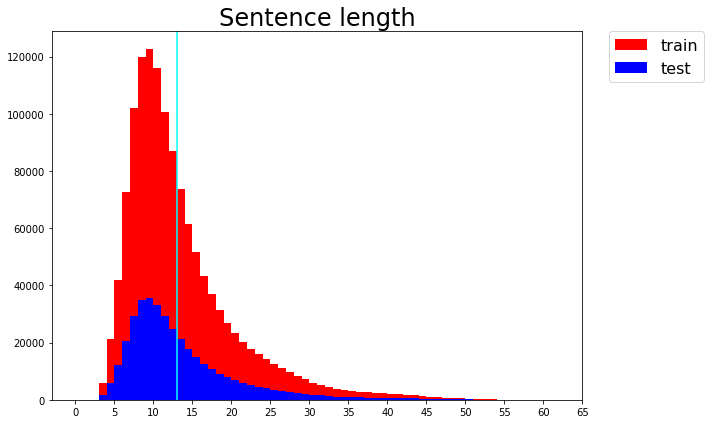

In [8]:
d_train = scipy.stats.describe(train_s_len)
d_test = scipy.stats.describe(test_s_len)
print(f"train: {d_train}")
print(f"test: {d_test}")

nb = 60

plt.figure(figsize=(10, 6))

plt.hist(train_s_len, bins=nb, range=[0, 60], facecolor='red', label='train')

plt.hist(test_s_len, bins=nb, range=[0, 60], facecolor='blue', label='test')
plt.axvline(x=d_test.mean, color='cyan')

plt.title("Sentence length", size=24)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., prop={'size': 16})
plt.xticks([5*i for i in range(14)])
plt.tight_layout()
plt.show()

In [14]:
_n = 5
print(train_vocab.most_common(_n))
print(train_vocab.most_common()[:-_n-1:-1])
print("-"*64)
print(test_vocab.most_common(_n))
print(test_vocab.most_common()[:-_n-1:-1])

[('the', 665875), ('what', 469057), ('is', 442981), ('a', 409758), ('to', 407907)]
[('statechart', 1), ('bangtanbomb', 1), ('arbitur', 1), ('uncalibrated', 1), ('12as', 1)]
----------------------------------------------------------------
[('the', 192786), ('what', 135120), ('is', 128051), ('to', 117614), ('a', 117570)]
[('lineral', 1), ('6740', 1), ('jingle', 1), ('horthy', 1), ('miklos', 1)]


In [20]:
test_not_in_train = []
train_not_in_test = []

for w in test_vocab:
    if w not in train_vocab:
        test_not_in_train += [w]

for w in train_vocab:
    if w not in test_vocab:
        train_not_in_test += [w]
        
uniq_words = set(train_vocab.keys()).union(set(test_vocab.keys()))
all_oov = Counter()

for w in uniq_words:
    if w not in emb_glove:
        all_oov[w] += 1
        
print(f"train not in test: {len(train_not_in_test)}")
print(f"test not in train: {len(test_not_in_train)}")
print(f"num uniq words: {len(uniq_words)}")

all_oov.most_common(10)

train not in test: 132537
test not in train: 31251
num uniq words: 238352


[('x2x1', 1),
 ('mycaster', 1),
 ('neovascularity', 1),
 ('rvunl', 1),
 ('celecelebrated', 1),
 ('sponteneously', 1),
 ('diwni', 1),
 ('internetichbinheir', 1),
 ('hiveswhy', 1),
 ('zolomon', 1)]

In [9]:
def get_emb_vocab_coverage(vocab, emb) -> (Counter, Counter):
    oov = Counter() # out-of-vocab
    inv = Counter() # in-vocab
    oov_uniq_num = inv_uniq_num = 0.0
    oov_all_num = inv_all_num = 0.0
    
    for w in tqdm(vocab):
        if w in emb:
            inv[w] = vocab[w]
            inv_uniq_num += 1
            inv_all_num += vocab[w]
        else:
            oov[w] = vocab[w]
            oov_uniq_num += 1
            oov_all_num += vocab[w]
    
    cov_uniq = 100.0 * round(inv_uniq_num / len(vocab), 5)
    cov_all = 100.0 * round(inv_all_num / (inv_all_num + oov_all_num), 5)
    
    print(f"oov_uniq: {oov_uniq_num}; inv_uniq: {inv_uniq_num}; all_uniq: {len(vocab)}")
    print("embeddings-vocabulary coverage (unique): %.3f%%" % cov_uniq)
    print("embeddings-vocabulary coverage (all text): %.3f%%" % cov_all)
    
    return oov, inv

In [10]:
oov, inv = get_emb_vocab_coverage(train_vocab, emb_glove)
oov.most_common(20)


oov_uniq: 81578.0; inv_uniq: 125523.0; all_uniq: 207101
embeddings-vocabulary coverage (unique): 60.610%
embeddings-vocabulary coverage (all text): 99.247%


[('paytm', 356),
 ('kvpy', 356),
 ('iiser', 346),
 ('iisc', 278),
 ('jinping', 211),
 ('viteee', 185),
 ('iocl', 177),
 ('nmims', 163),
 ('rohingya', 157),
 ('upes', 157),
 ('iitians', 147),
 ('cpec', 146),
 ('nsit', 145),
 ('coinbase', 145),
 ('jadavpur', 138),
 ('oneplus', 138),
 ('udemy', 126),
 ('lyft', 125),
 ('bahubali', 123),
 ('uceed', 123)]

In [12]:
oov, inv = get_emb_vocab_coverage(test_vocab, emb_glove)
oov.most_common(20)


oov_uniq: 27594.0; inv_uniq: 78221.0; all_uniq: 105815
embeddings-vocabulary coverage (unique): 73.922%
embeddings-vocabulary coverage (all text): 99.245%


[('paytm', 104),
 ('iisc', 89),
 ('kvpy', 85),
 ('jinping', 76),
 ('iiser', 75),
 ('nmims', 58),
 ('viteee', 51),
 ('rohingya', 47),
 ('nsit', 45),
 ('upes', 45),
 ('udemy', 45),
 ('iocl', 44),
 ('laravel', 39),
 ('afcat', 38),
 ('oneplus', 38),
 ('vishwanathan', 37),
 ('nlu', 37),
 ('lyft', 35),
 ('boruto', 34),
 ('sjws', 34)]

# Model

In [115]:
class Net(nn.Module):
    def __init__(self, emb_matrix, hidden_size):
        super(Net, self).__init__()

        # GloVe emb matrix
        num_words, emb_size = emb_matrix.shape

        self.hidden_size = hidden_size

        self.embedding = nn.Embedding(num_words, emb_size)
        self.embedding.weight = nn.Parameter(torch.tensor(emb_matrix, dtype=torch.float32))
        self.embedding.weight.requires_grad = False
        
        self.lstm = nn.LSTM(
            input_size=emb_size,
            hidden_size=self.hidden_size,
            num_layers=1,
            bidirectional=True,
            batch_first=True
        )

        self.gru = nn.GRU(
            input_size=2*self.hidden_size,
            hidden_size=self.hidden_size,
            num_layers=1,
            bidirectional=True,
            batch_first=True
        )

        self.fc = nn.Linear(2 * self.hidden_size, 1)

        self.dropout = nn.Dropout(0.1)
        self.relu = nn.ReLU()

    def forward(self, x):
        # x: B x sen_maxlen

        emb = self.embedding(x)
        # B x sen_maxlen x emb_size

        out_lstm, _ = self.lstm(emb)
        # B x sen_maxlen x (2*sen_maxlen)
        
        _, h_gru = self.gru(self.dropout(out_lstm))
        # 2 x B x sen_maxlen
        
        h_gru = h_gru.permute((1, 0, 2)).reshape(x.size(0), -1)
        # B x (2*sen_maxlen)
        
        out = self.fc(h_gru).unsqueeze(0)
        # 1 x B x 1
        
        return out

# --

x = torch.zeros((bs, 70), dtype=torch.long)
m = Net(emb_matrix=np.load("glove_embedding_matrix.npy"), hidden_size=70)

y = m(x)

y.size()

torch.Size([1, 12, 1])